# Imports

In [106]:
import pandas as pd
import numpy as np

import os # 파일 경로 처리
from tqdm import tqdm

from sympy import Symbol, solve, integrate # Z(x) 방정식을 세우고, 해를 구해줌 
from scipy.optimize import fminbound # 최소값을 만들어주는 alpha를 구하기 위해 사용

from datetime import datetime # 코드 처리 시간 산정

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt # 그래프를 그려주는 함수

# Define Functions
* 필요 함수 정의

In [2]:
def preprocessing(network):
    """네트워크 객체의 컬럼 이름 및 순서를 정리한 데이터프레임을 만들어주는 함수.
    - O, D, FFT, alpha, Capacity, beta, Length 등의 컬럼만 남기고 나머지는 사용하지 않는다.
    """
    net = pd.DataFrame({
        'O' : network['Init node '], # 링크 시작점
        'D' : network['Term node '], # 링크 끝점
        'FFT' : network['Free Flow Time '], # Free Flow Time. t_0이라 보면 된다.
        'Power' : network['Power'],
        'Capacity' : network['Capacity '], # 링크 용량
        'B' : network['B'].round(2),
        'Length' : network['Length '],
        #'Toll' : network['Toll '],
        'Link_num' : [i for i in range(1, len(network)+1)], # 각 링크의 번호
        'x_n' : 0, # 매 iteration마다 배정된 링크 용량이 저장될 컬럼
        'y_n' : 0,
        'Direction' : 0,
        'x_n1' : 0,
        'Cost' : 0 # 매 iteration마다 산정될 비용이 저장될 컬럼
    })
   
    net = net.sort_values(by = ['O', 'D']) # net1 데이터프레임을 O, D에 대하여 오름차순 정렬
    net.set_index('Link_num', drop = False, inplace = True)# 링크 번호로 네트워크 각 링크의 인덱스를 지정
    
    return net

In [3]:
def node_range(network):
    """Sioux-Falls Network의 각 노드에서 출발하는
    링크 번호의 범위를 데이터프레임으로 저장하는 함수"""
    
    origin_nodes = network['O'].unique()
    start_list = []
    end_list = []
    
    for origin in origin_nodes:
        link_list = network[network['O'] == origin]['Link_num'] # 기점이 origin인 모든 링크 번호 리스트 추출
        link_list.sort_values() # 기점 origin에 연결된 링크 번호들을 오름차순으로 정렬
        
        start = link_list.iloc[0] # 링크 리스트의 첫번째 링크(가장 먼저 번호 링크)
        end = link_list.iloc[-1] # 링크 리스트의 마지막 링크(가장 마지막 번호 링크)
        
        start_list.append(start)
        end_list.append(end)
        
    node_link_df = pd.DataFrame({
        'origin' : origin_nodes,
        'start_link' : start_list,
        'end_link' : end_list
    })
    
    node_link_df.set_index('origin', drop = False, inplace = True) # 링크 번호로 네트워크 각 링크의 인덱스를 지정해 준다.
    
    return node_link_df

In [4]:
def calculate_cost(network):
    """
    링크 통행비용을 계산하는 함수.
    :: 필요 변수 :: FFT, Power, B, X0, Capacity
    :: BPR 함수 :: Cost = Free Flow Time * (1 + (B * (X_n / Capacity))**Power)
    """
    network['Cost'] = network['FFT'] * (1 + network['B'] * ((network['x_n'] / network['Capacity']) ** network['Power'])) #+ (net1['Length'] * net1['Toll'])
    
    return network

In [5]:
def make_graph(network):
    """네트워크 데이터프레임을 투입하여,
    Dijkstra 방식의 Shortest Path를 구할 수 있도록
    Dictionary를 활용한 graph 객체를 만들어주는 함수"""
    
    origin_array = np.array(network['O'].unique())
    
    graph = {} # 빈 딕셔너리 생성

    for origin in origin_array:
    
        origin_rows = network[network['O'] == origin]
    
        destin_array = np.array(origin_rows['D'])
        link_num_array = np.array(origin_rows['Link_num'])
        cost_array = np.array(origin_rows['Cost'])
    
        tup_dict = {}
    
        for destin, link_num, cost in zip(destin_array, link_num_array, cost_array):
            #tup_list.append((destin, link_num, cost))
            tup_dict[destin] = (link_num, cost)
    
        graph[origin] = tup_dict
    
    return graph

In [6]:
def Dijkstra(network, O, D):
    """ 해당 네트워크(network)의 각 기점(O), 종점(D)에 대해
    Dijkstra 방식의 최단경로 링크 리스트를 추출해주는 함수"""
    
    graph = make_graph(network)
    
    path = {} #최단경로 저장
    adj_node = {} #인접노드
    
    queue = []
    
    for node in graph: # 모든 노드 체크, 경로 초기화
        path[node] = float('inf')
        adj_node[node] = None
        queue.append(node)

    path[O] = 0
    
    while queue: # 방문한 노드 및 각 노드 사이의 최소경로 검색
        key_min = queue[0]
        min_val = path[key_min]
        
        for n in range(1, len(queue)):
            if path[queue[n]] < min_val:
                key_min = queue[n]
                min_val = path[key_min]
        
        cur = key_min
        queue.remove(cur)

        for i in graph[cur]:
            alternate = graph[cur][i][1] + path[cur]
            
            if path[i] > alternate:
                path[i] = alternate
                
                adj_node[i] = cur
                
    nodes = [D]
    
    while True:
        D = adj_node[D]
        if D is None:
            break
        nodes.append(D)
    
    nodes.reverse()

    links = []
    
    for i in range(len(nodes)-1):
        link = graph[nodes[i]][nodes[i+1]][0]
        links.append(link)
        
    return links #,nodes # 각 O-D별 최단경로의 경유링크를 반환함. 해당 비용 또는 경유노드(nodes)도 반환할 수 있음

In [7]:
def line_search(alpha):
    """네트워크 파일의 값으로부터 alpha값을 계산하기 위한
    방정식을 반환하는 함수"""
    
    ls = 0 # alpha 값을 계산하기 위한 식을 반환

    for i in range(1, len(net_cost)+1): # 1부터 끝까지 Link_num == i에 대하여
        t = net_cost.loc[i, 'FFT']
        B = net_cost.loc[i, 'B']
        P = net_cost.loc[i, 'Power']
        C = net_cost.loc[i, 'Capacity']
        d = net_cost.loc[i, 'Direction']
        x = net_cost.loc[i, 'x_n']
        
        equation = t * (x + alpha * d) + (t * B/((P+1) * C**P)) * (x + alpha * d)**(P+1) ## 손으로 적분한 식
        
        ls += equation
    
    return ls

In [8]:
def calculate_Z(network):
    """네트워크 파일로부터 Z(x) 값 계산해 반환하는 함수"""
    ## Sympy :: 방정식을 풀기 위한 패키지
    
    ## 방정식에 포함될 각 변수들을 선언
    d = Symbol('d') # direction
    B = Symbol('B') # B. 0.15 ~ 0.25
    t = Symbol('t') # t. Cost
    c = Symbol('c') # capacity
    x = Symbol('x') # x0
    alpha = Symbol('alpha')
    P = Symbol('P') # Power 2 ~ 4 
    
    z_x = 0

    for i in range(1, len(net_cost)+1): # 1부터 끝까지 Link_num == i에 대하여
        t = network.loc[i, 'FFT']
        B = network.loc[i, 'B']
        P = network.loc[i, 'Power']
        C = network.loc[i, 'Capacity']
    
        equation = t * (1 + B * ((x/C)**P))
    
        xa = network.loc[i, 'x_n']

        integ = integrate(equation, (x, 0, xa))
    
        z_x += integ
    
    return z_x

In [9]:
def convergence_test(network):
    """각 iteration마다 해당 네트워크에 대해
    convergence test를 실행하기 위한 값을 반환하는 함수."""
    
    sum_xn = sum(network['x_n'])
    sum_varx = sum((network['x_n1'] - network['x_n']) ** 2)**(1/2)
    
    score = sum_varx / sum_xn
        
    return score

# Data settings
* 데이터 불러오기

In [10]:
data_dir = 'dataset'

In [11]:
network_file = 'Network.csv'
network_path = os.path.join(data_dir, network_file)

In [12]:
OD_file = 'OD.csv'
OD_path = os.path.join(data_dir, OD_file)

In [13]:
network = pd.read_csv(network_path, encoding = 'UTF-8')

In [14]:
OD = pd.read_csv(OD_path, encoding = 'UTF-8')

In [15]:
network

,Init node,Term node,Free Flow Time,Capacity,Length,B,Power,Speed.limit,Toll1,Toll2,Type
0,1,2,6,25900.200640,6,0.15,4,0,0,0,1
1,1,3,4,23403.473190,4,0.15,4,0,0,0,1
2,2,1,6,25900.200640,6,0.15,4,0,0,0,1
3,2,6,5,4958.180928,5,0.15,4,0,0,0,1
4,3,1,4,23403.473190,4,0.15,4,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,4,5000.000000,4,0.25,2,0,0,0,1
72,23,24,2,5078.508436,2,0.25,2,0,0,0,1
73,24,13,4,5091.256152,4,0.25,2,0,0,0,1
74,24,21,3,4885.357564,3,0.25,2,0,0,0,1


In [16]:
OD

,O,D,T
0,1,1,0
1,1,2,100
2,1,3,100
3,1,4,500
4,1,5,200
...,...,...,...
571,24,20,400
572,24,21,500
573,24,22,1100
574,24,23,700


# Initialization
* **`N = 0`**
* 초기 비용 계산 : $x_0$ = 0 (모든 링크의 통행량 = 0)인 상태에서 비용 계산
* 초기 배정 : All-or-Nothing 방식으로 통행 배정, $x_1$ 획득

## Data Ready

In [17]:
net1 = preprocessing(network)

In [18]:
net1.head()

,O,D,FFT,Power,Capacity,B,Length,Link_num,x_n,y_n,Direction,x_n1,Cost
Link_num,,,,,,,,,,,,,
1,1,2,6,4,25900.200640,0.15,6,1,0,0,0,0,0
2,1,3,4,4,23403.473190,0.15,4,2,0,0,0,0,0
3,2,1,6,4,25900.200640,0.15,6,3,0,0,0,0,0
4,2,6,5,4,4958.180928,0.15,5,4,0,0,0,0,0
5,3,1,4,4,23403.473190,0.15,4,5,0,0,0,0,0


## 초기 비용 계산 : $t_a(x_a^0)$
* $x_0$ = 0 (전부 0)임을 계산하여 Cost 계산

In [19]:
net_cost = calculate_cost(net1) # x0 

In [20]:
net_cost

,O,D,FFT,Power,Capacity,B,Length,Link_num,x_n,y_n,Direction,x_n1,Cost
Link_num,,,,,,,,,,,,,
1,1,2,6,4,25900.200640,0.15,6,1,0,0,0,0,6.0
2,1,3,4,4,23403.473190,0.15,4,2,0,0,0,0,4.0
3,2,1,6,4,25900.200640,0.15,6,3,0,0,0,0,6.0
4,2,6,5,4,4958.180928,0.15,5,4,0,0,0,0,5.0
5,3,1,4,4,23403.473190,0.15,4,5,0,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,23,22,4,2,5000.000000,0.25,4,72,0,0,0,0,4.0
73,23,24,2,2,5078.508436,0.25,2,73,0,0,0,0,2.0
74,24,13,4,2,5091.256152,0.25,4,74,0,0,0,0,4.0


## $x_1$ 획득 : AON Assignment

In [21]:
# 각 OD별로 Dijkstra를 사용해 최단경로를 산출, 
# OD 테이블의 교통량(T)을 각 최단경로에 포함된 링크에 All-or-Nothing으로 배정하기

origin_list = OD['O'].unique()

total_link_list = []
total_addvolume_list = []

for origin in tqdm(origin_list): # 각 Origin에 대하여

    each_origin_OD = OD[OD['O'] == origin] 
    destination_list = each_origin_OD['D'] # 지정된 기점(Origin)에 대한 종점 리스트 추출
    
    for destination in destination_list: # 각 Origin의 Destin에 대하여
        if origin != destination:
            link_list = Dijkstra(net_cost, origin, destination) # OD별 shortest path 링크 넘버 추출
            # 각 링크넘버에 OD 테이블의 교통량(T) 더해주기
            add_volume = OD[(OD['O'] == origin) & (OD['D'] == destination)].iloc[0].loc['T'] # 각 통과 링크에 더해줄 OD 교통량 산정 
                
            total_link_list.append(link_list)
            total_addvolume_list.append(add_volume)
                
        else:
            pass
        
for link_list, add_volume in zip(total_link_list, total_addvolume_list):
    net_cost.loc[net_cost['Link_num'].isin(link_list), 'x_n'] += add_volume # All or Nothing 배정 :: xn 갱신

100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:06<00:00,  3.80it/s]


In [22]:
net_cost

,O,D,FFT,Power,Capacity,B,Length,Link_num,x_n,y_n,Direction,x_n1,Cost
Link_num,,,,,,,,,,,,,
1,1,2,6,4,25900.200640,0.15,6,1,3800,0,0,0,6.0
2,1,3,4,4,23403.473190,0.15,4,2,6000,0,0,0,4.0
3,2,1,6,4,25900.200640,0.15,6,3,3800,0,0,0,6.0
4,2,6,5,4,4958.180928,0.15,5,4,6600,0,0,0,5.0
5,3,1,4,4,23403.473190,0.15,4,5,6000,0,0,0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,23,22,4,2,5000.000000,0.25,4,72,10800,0,0,0,4.0
73,23,24,2,2,5078.508436,0.25,2,73,5700,0,0,0,2.0
74,24,13,4,2,5091.256152,0.25,4,74,10800,0,0,0,4.0


## Define Constant

In [23]:
## Sympy :: 방정식을 풀기 위한 패키지 이용. 방정식에 포함될 각 변수들을 미리 선언하기
d = Symbol('d') # direction
B = Symbol('B') # B
t = Symbol('t') # t. Cost
c = Symbol('c') # capacity
x = Symbol('x') # x0
alpha = Symbol('alpha') # alpha
P = Symbol('P') # Power

In [24]:
k = 0.001 ### Convergence test 통과 기준

In [25]:
z_list = [] # iteration 별 Z(x) 값을 저장할 빈 리스트 생성
convergence_list = [] # iteration별 convergence test 용 점수를 저장할 빈 리스트 생성

In [26]:
net_cost.head(3)

,O,D,FFT,Power,Capacity,B,Length,Link_num,x_n,y_n,Direction,x_n1,Cost
Link_num,,,,,,,,,,,,,
1,1,2,6,4,25900.20064,0.15,6,1,3800,0,0,0,6.0
2,1,3,4,4,23403.47319,0.15,4,2,6000,0,0,0,4.0
3,2,1,6,4,25900.20064,0.15,6,3,3800,0,0,0,6.0


# Iteration
* `while True:`를 사용해서 convergence test를 통과할 때까지 무한반복

In [27]:
print('====================================================')
print(f'● Initialization ●')
print('====================================================')
print(net_cost[['x_n', 'y_n', 'Cost', 'Direction', 'x_n1']].head())

start_time = datetime.now()

iteration = 1

while True:
    print('\n')
    print('====================================================')
    print(f'● Iteration : {iteration} ● ')
    print('====================================================')
    
    ######### Update Link Travel Time. t1계산. 통행비용을 cost 열에 갱신.
    ######### 전 iteration 단계에서 계산한 통행량 xn으로 통행비용 tn 계산함
    net_cost = calculate_cost(net_cost) 
    
    ######### 갱신된 통행비용 tn(Cost) 및 xn을 이용하여 Dijkstra 방식으로 Shortest Path를 산정
    ######### All-or-Nothing Assignment 실행, y_n 획득
    
    total_link_list = []
    total_addvolume_list = []
    
    for origin in origin_list: # 각 Origin에 대하여

        each_origin_OD = OD[OD['O'] == origin]
        destination_list = each_origin_OD['D']    
    
        for destination in destination_list: # 각 Origin의 Destin에 대하여
            if origin != destination:
                link_list = list(Dijkstra(net_cost, origin, destination)) # OD별 shortest path 링크 넘버 추출
                # 각 링크넘버에 OD 테이블의 교통량(T) 더해주기
                add_volume = OD[(OD['O'] == origin) & (OD['D'] == destination)].iloc[0].loc['T'] # 각 통과 링크에 더해줄 OD 교통량 산정 
                #print(f'({origin}, {destination}) = {link_list}, {add_volume}')
                
                total_link_list.append(link_list)
                total_addvolume_list.append(add_volume)
                #net_cost.loc[net_cost['Link_num'].isin(link_list), 'y_n'] += add_volume # All or Nothing 배정 :: yn 갱신
                
            else:
                pass
            
    for link_list, add_volume in zip(total_link_list, total_addvolume_list):
        net_cost.loc[net_cost['Link_num'].isin(link_list), 'y_n'] += add_volume # All or Nothing 배정 :: yn 갱신
        #print(f'Link_num : {link_list} added volume {add_volume}.')
    
        
    ######### Find Move Size Alpha. 목적함수 Z(x)를 최소화하는 Alpha 값 찾기
    ######### Find Direction d = yn - xn
    ######### scipy.optimize.fminbound를 이용해 0 이상 1 이하의 Alpha 를 구한다
    
    net_cost['Direction'] = net_cost['y_n'] - net_cost['x_n'] # direction :: d = yn - xn 임
    
    ith_alpha = fminbound(line_search, 0, 1) ### line_search 함수식을 만족시키는 0이상 1이하의 alpha 값을 구함
    
    ######### x_n값 및 Alpha 이용, >> x_n1 컬럼 값 생성     
    net_cost['x_n1'] = net_cost['x_n'] + ith_alpha * (net_cost['Direction']) # 금번 iteration의 Alpha 값을 이용, x_n+1 값을 계산해준다.
    
    print(net_cost[['x_n', 'y_n', 'Cost', 'Direction', 'x_n1']].head())
    print(f'Alpha = {ith_alpha}')
    
    ######### Z(x) 계산 
    z = calculate_Z(net_cost)
    z_list.append(z)
    print(f'Z(x) = {z}')
    
    ######### Convergence Test 실행 :
    ######### 만약 Convergence Test를 통과할 경우 본 while문은 깨bb지고 결과를 출력하면 된다.
    ######### 만약 통과하지 못하면 본 iteration은 계속 반복된다.
    
    convergence = convergence_test(net_cost) # False가 저장될 시, 위 과정을 반복한다.
    print(f'Convergence Score = {convergence}')
    
    convergence_list.append(convergence)
   
    if convergence <= k : # Convergence Test 통과 시 While문이 종료된다.
        end_time = datetime.now()
        
        print(f'Process is finished : {end_time - start_time} seconds passed.')
        break
        
    else:
        net_cost['x_n'] = net_cost['x_n1'].copy()
        net_cost['y_n'] = 0 # 초기화해주지 않으면 엄청 늘어나버린다.
        net_cost['Direction'] = 0
        net_cost['x_n1'] = 0
        iteration +=1
        
        end_time = datetime.now()
        
        print(f'Iteration is ongoing : {end_time - start_time} passed.')

● Initialization ●
           x_n  y_n  Cost  Direction  x_n1
Link_num                                  
1         3800    0   6.0          0     0
2         6000    0   4.0          0     0
3         3800    0   6.0          0     0
4         6600    0   5.0          0     0
5         6000    0   4.0          0     0


● Iteration : 1 ● 
           x_n    y_n      Cost  Direction         x_n1
Link_num                                               
1         3800   4900  6.000417       1100  4190.722590
2         6000  13000  4.002592       7000  8486.416482
3         3800   5000  6.000417       1200  4226.242826
4         6600   1700  7.354765      -4900  4859.508462
5         6000  12900  4.002592       6900  8450.896247
Alpha = 0.3552023546108334
Z(x) = 7121584.07999858
Convergence Score = 0.04863924914843371
Iteration is ongoing : 0:00:07.686481 passed.


● Iteration : 2 ● 
                  x_n    y_n      Cost    Direction         x_n1
Link_num                                    

# Show Some Properties

In [86]:
iteration_list = [i for i in range(1, len(z_list)+1)]

## $Z(x)$

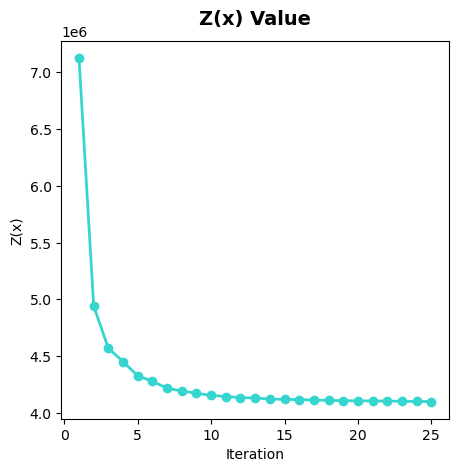

In [129]:
plt.figure(figsize = (5, 5), dpi = 100) # figsize = 그래프 크기, dpi = dot per inch

title_font = {
    'fontsize' : 14,
    'fontweight' : 'bold'
}

plt.plot(iteration_list, z_list, color = '#36D5D0', linewidth = 2.0, marker = 'o')

plt.title('Z(x) Value', loc = 'center', pad = 12, fontdict = title_font) # 그래프 제목 
plt.xlabel('Iteration') # x축 이름
plt.ylabel('Z(x)') # y축 이름

z_img_path = os.path.join(data_dir, 'z.png')
plt.savefig(z_img_path)

#plt.show()

## Convergence Score

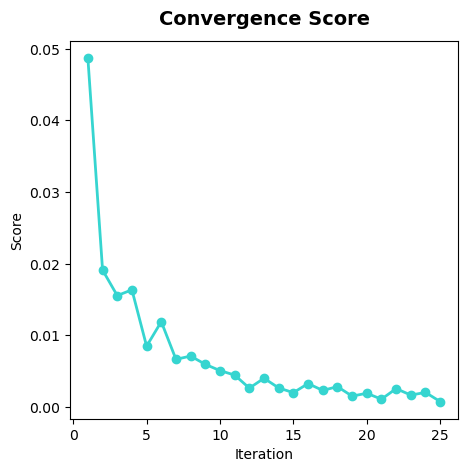

In [130]:
plt.figure(figsize = (5, 5), dpi = 100) # figsize = 그래프 크기, dpi = dot per inch

#fm.get_fontconfig_fonts()
##font_location = 'C:/Users/User/AppData/Local/Microsoft/Windows/Fonts/KoPubWorld Dotum Bold.ttf' # For Windows
#font_name = fm.FontProperties(fname = font_location).get_name()
#matplotlib.rc('font', family = font_name)

title_font = {
    'fontsize' : 14,
    'fontweight' : 'bold'
}

plt.plot(iteration_list, convergence_list, color = '#36D5D0', linewidth = 2.0, marker = 'o')

plt.title('Convergence Score', loc = 'center', pad = 12, fontdict = title_font) # 그래프 제목 
plt.xlabel('Iteration') # x축 이름
plt.ylabel('Score') # y축 이름

#plt.show()

convergence_img_path = os.path.join(data_dir, 'convergence_score.png')
plt.savefig(convergence_img_path)

# Save UE Result

In [89]:
result_file_name = 'UE_result.csv'
result_file_path = os.path.join(data_dir, result_file_name)

In [90]:
net_cost.to_csv(result_file_path, encoding = 'UTF-8')